In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

注：参考原文链接：https://github.com/Alexdachen/ivix

In [2]:
options_data = pd.read_excel('/Users/options_data.xlsx',index_col=0)
options_data.head()

,SEC_NAME,EXE_MODE,EXE_PRICE,EXE_ENDDATE,CLOSE
date,,,,,
2015-03-25,10000001,认购,2.2,2015-03-25,0.4040
2015-03-24,10000001,认购,2.2,2015-03-25,0.4415
2015-03-23,10000001,认购,2.2,2015-03-25,0.4765
2015-03-20,10000001,认购,2.2,2015-03-25,0.4363
2015-03-19,10000001,认购,2.2,2015-03-25,0.3902


In [3]:
options_data.columns = ['code','type','strike','expdate','close']
options_data.type = options_data.type.map({'认购':'C','认沽':'P'})

In [4]:
options_data['expdate']=pd.to_datetime(options_data['expdate'])
options_data.index = pd.to_datetime(options_data.index)

In [5]:
def caculateNearNextExpDate(ivx_date,option):
    """
    筛选近月次月期权
    """
    options = option
    options['days'] = (options['expdate'] - options.index).dt.days.map(int)
    options = options[options.days>7]
    expdate = options.sort_values('expdate')['expdate'].dt.date.unique()
    days = options.sort_values('days')['days'].unique()
    near_date = expdate[0]
    next_date =expdate[1]
    NT1 = days[0]
    NT2 =days[1]
    return near_date,next_date,NT1,NT2

In [6]:
def caculateMinGapStrike(date,option):
    """
        计算认购期权价格与认沽期权价格相差最小的执行价和对应的价差
        date:到期日期
        return : 最小价差对应的执行价,最小价差,所有执行价构成的列表 
    """
    options = option
    option = options[(options['expdate'].dt.date==date)]
    # option
    option = pd.pivot_table(option,index='strike',columns='type',values='close')
    option['C_P'] = option['C'] - option['P']
    option['abs_gap'] = option['C_P'].abs()
    option = option.sort_values('abs_gap')
    atm_strike = option.index[0]
    min_gap = option['abs_gap'].values[0]
    return atm_strike,min_gap,option.index.tolist()

In [7]:
def caculateFK0(near_date,next_date,option):
    options = option
    S1,gap1,S1_list = caculateMinGapStrike(near_date,options)
    S2,gap2,S2_list = caculateMinGapStrike(next_date,options)
    T1 = NT1/365.
    T2 = NT2/365.
    F1 = S1+np.exp(T1*R)*gap1
    F2 = S2+np.exp(T2*R)*gap2
    #K0为稍小于F并离F最近的可用执行价
    K01 = np.max([i for i in S1_list if i <=F1])
    K02 = np.max([i for i in S2_list if i <=F2])
    return F1,F2,K01,K02,T1,T2

In [8]:
def caculateSigma(date,K0,T,R,F,option):
    options = option
    option = options[(options['expdate'].dt.date==date)]
    # option = pd.pivot_table(option,index='strike',columns='type',values='close')
    option.sort_values('strike',inplace=True)
    otm_put = option[(option['strike']<K0)&(option['type']=='P')]
    otm_call = option[(option['strike']>K0)&(option['type']=='C')]
    atm = option[option['strike']==K0]
    atm['close'] =atm['close'].mean()
    atm['type'] = 'mix'
    
    option = otm_put.append(atm.iloc[[0]]).append(otm_call)
    option.sort_values('strike',inplace=True)
    option['delta_K'] = option['strike'].diff()
    option.iloc[0,-1] =option.iloc[1,-1]
    option['T'] = T
    option['R'] = R 
    option['var'] = option.apply(lambda x : (x['delta_K']/x['strike']**2)*np.exp(x['R']*x['T'])*x['close'],axis=1)
    var = option['var'].sum()
    sigma = (2/T)*var - (1/T)*(F/K0 - 1)**2
    return sigma

In [9]:
def caculateIVX(sigma1,sigma2):
    ivx = None
    ivx = 100*((T1*sigma1*((NT2-30)/(NT2-NT1)) + T2*sigma2*((30-NT1)/(NT2-NT1)))*(365/30))**0.5
    return ivx

In [10]:
days = []
ivx_list =[]
R  = 0.3
for ivx_date in options_data.sort_index().index.unique():
    days.append(ivx_date)
    options = options_data.loc[ivx_date].copy()
    near_date,next_date,NT1,NT2 = caculateNearNextExpDate(ivx_date,options)
    F1,F2,K01,K02,T1,T2= caculateFK0(near_date,next_date,options)
    sigma1 = caculateSigma(near_date,K01,T1,R,F1,options)
    sigma2 = caculateSigma(next_date,K02,T2,R,F2,options)
    ivx = caculateIVX(sigma1,sigma2)
    ivx_list.append(ivx)

In [11]:
days= [i.date() for i in days]

In [55]:
dates = pd.DataFrame(days)
dates.columns = ['date']

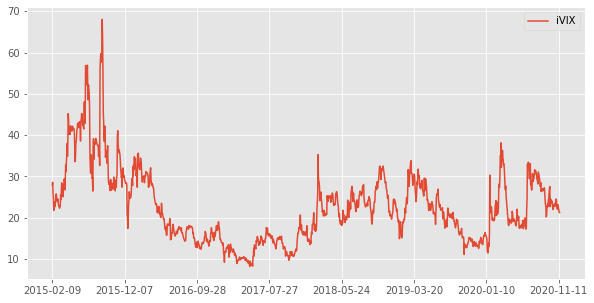

In [12]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(ivx_list,label='iVIX')
plt.xticks(range(len(days))[::200],days[::200])
plt.legend()
plt.show()

In [43]:
ivix = pd.DataFrame(ivx_list , columns = ['ivix'])

In [57]:
iVIX = pd.concat([dates , ivix],axis=1,join='outer')

In [58]:
iVIX

,date,ivix
0,2015-02-09,27.889018
1,2015-02-10,28.549065
2,2015-02-11,25.755854
3,2015-02-12,24.619843
4,2015-02-13,21.741204
...,...,...
1399,2020-11-10,22.968780
1400,2020-11-11,22.414297
1401,2020-11-12,21.972942
1402,2020-11-13,21.238315


In [60]:
iVIX.to_excel('/Users/无模型隐含波动率.xlsx')